In [3]:
import numpy as np
import os
from scipy.signal import find_peaks

PATH = "/home/navanerj/Documents/Model/DATA_JULY10/random"
MAX_ROWS = 10000
ROUND1_START = 20000
ROUND1_END = 25000

AES_SBOX = [0x6, 0xB, 0x5, 0x4, 0x2, 0xE, 0x7, 0xA,0x9, 0xD, 0xF, 0xC, 0x3, 0x1, 0x0, 0x8]
type_converter = {i: lambda x: int(x, 16) for i in range(16)}
random_plaintexts = np.loadtxt(os.path.join(PATH,"plaintexts.txt"), dtype=np.uint8, max_rows=MAX_ROWS, converters=type_converter)
random_traces = np.loadtxt(os.path.join(PATH,"traces.txt"), max_rows=MAX_ROWS)
unscaled_traces = random_traces[:,ROUND1_START:ROUND1_END]
SCALE = 3
m_off = 0
scaled_traces = ((unscaled_traces / 127) * 4) * SCALE + m_off

print("unscaled traces shape: ", unscaled_traces.shape)
print("scaled traces shape: ", scaled_traces.shape)

unscaled traces shape:  (10000, 5000)
scaled traces shape:  (10000, 5000)


In [ ]:
def hamming_weight(arr):
    """Vectorized Hamming weight for 4-bit values (0-15)."""
    return ((arr & 1) + ((arr >> 1) & 1) + ((arr >> 2) & 1) + ((arr >> 3) & 1)).astype(np.float64)

def compute_entropy(probs):
    """Compute entropy from probability distribution."""
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

def compute_mi(trace_col, model_col, num_bins=32, trace_range=4.0):
    """
    Compute mutual information I(trace; model) = H(trace) - H(trace | model)
    using histogram estimation.
    """
    n_traces = len(trace_col)
    trace_mean = np.mean(trace_col) 
    trace_std = np.std(trace_col) + 1e-10
    trace_norm = (trace_col - trace_mean) / trace_std
    
    bins = np.linspace(-trace_range, trace_range, num_bins + 1)
    
    # H(trace): Marginal entropy
    counts_trace, _ = np.histogram(trace_norm, bins=bins)
    probs_trace = counts_trace / n_traces
    h_trace = compute_entropy(probs_trace)
    
    # H(trace | model): Conditional entropy
    h_cond = 0.0
    unique_models = np.unique(model_col)
    for m in unique_models:
        idx = (model_col == m)
        sub_trace = trace_norm[idx]
        sub_n = len(sub_trace)
        if sub_n == 0:
            continue
        counts_m, _ = np.histogram(sub_trace, bins=bins)
        probs_m = counts_m / sub_n
        h_m = compute_entropy(probs_m)
        h_cond += (sub_n / n_traces) * h_m
    
    mi = h_trace - h_cond
    return mi if mi > 0 else 0.0  # Clamp negative due to estimation error

Window length: 5000, Number of traces: 10000, Number of bytes: 16
MI-based top 4 leakage points per byte (unmasked, using HW model):
Byte 0: [2933, 3896, 2036, 3890]
Byte 1: [3112, 2777, 2285, 3109]
Byte 2: [3645, 409, 3103, 351]
Byte 3: [4120, 4273, 822, 2787]
Byte 4: [3834, 3723, 2393, 4491]
Byte 5: [3821, 3459, 4687, 2908]
Byte 6: [1701, 4180, 4399, 868]
Byte 7: [1988, 4531, 4063, 2904]
Byte 8: [477, 2453, 2534, 3971]
Byte 9: [4638, 3193, 1500, 419]
Byte 10: [2657, 4600, 1018, 4247]
Byte 11: [1608, 651, 2938, 3527]
Byte 12: [2674, 2667, 2938, 2823]
Byte 13: [2625, 952, 507, 2666]
Byte 14: [3844, 4152, 639, 2020]
Byte 15: [2742, 2768, 2672, 2185]


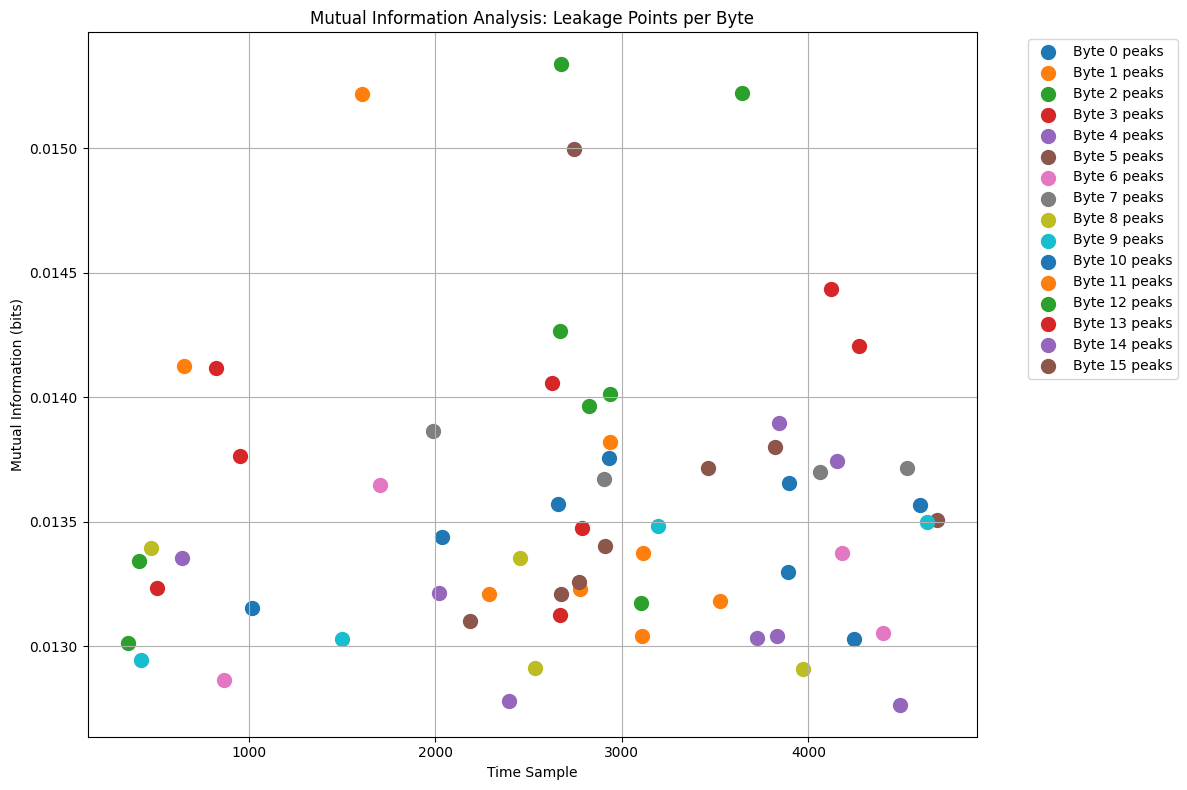

In [6]:
import matplotlib.pyplot as plt
n_traces, segment_length = unscaled_traces.shape
n_bytes = random_plaintexts.shape[1]
time_indices_mi = [[] for _ in range(n_bytes)] 

window_start, window_end = 0, segment_length
window_length = window_end - window_start
print(f"Window length: {window_length}, Number of traces: {n_traces}, Number of bytes: {n_bytes}")
mi_arrays = np.zeros((n_bytes, window_length))

for byte in range(n_bytes):
    # Model: Hamming weight of plaintext byte
    plain_b = random_plaintexts[:, byte]
    model_b = hamming_weight(plain_b)
    
    # Compute MI for each time point
    mi_arr = np.zeros(window_length)
    for j in range(window_length):
        trace_idx = window_start + j
        mi_arr[j] = compute_mi(unscaled_traces[:, trace_idx], model_b)
    
    mi_arrays[byte] = mi_arr
    
    # Find peaks (local maxima) in MI array
    min_prominence = max(0.05 * np.max(mi_arr), 0.01)
    peaks, properties = find_peaks(mi_arr, prominence=min_prominence, height=(None, None))
    
    if len(peaks) > 0:
        # Sort peaks by height (MI value) descending
        peak_heights = properties['peak_heights']
        sorted_idx = np.argsort(peak_heights)[::-1]
        top_peaks = peaks[sorted_idx][:4]  # Top 4, or fewer if less available
        time_indices_mi[byte] = (window_start + top_peaks).tolist()
    else:
        # Fallback to top 4 by raw MI
        top_indices = np.argsort(mi_arr)[-4:][::-1]
        time_indices_mi[byte] = (window_start + top_indices).tolist()


print("MI-based top 4 leakage points per byte (unmasked, using HW model):")
for byte in range(n_bytes):
    print(f"Byte {byte}: {time_indices_mi[byte]}")

plt.figure(figsize=(12, 8))
for byte in range(n_bytes):
    # plt.plot(mi_arrays[byte], label=f"Byte {byte}", alpha=0.7)
    if time_indices_mi[byte]:
        plt.scatter(time_indices_mi[byte], mi_arrays[byte][time_indices_mi[byte]], 
                   marker='o', s=100, label=f"Byte {byte} peaks")

plt.title("Mutual Information Analysis: Leakage Points per Byte")
plt.xlabel("Time Sample")
plt.ylabel("Mutual Information (bits)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
properties

{'prominences': array([0.01090794, 0.02026061, 0.00814688, ..., 0.0091646 , 0.00686252,
        0.00927682]),
 'left_bases': array([    10,     10,     19, ...,  99992, 100002, 100002]),
 'right_bases': array([    15,    144,     28, ..., 100011, 100004, 100011])}